## Forward dynamics and Inverse dynamics in MyoSuite for students

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import glob
import os
from mjid import MjID
from myoutils import generate_plot, VideoGenerator
from scipy.interpolate import interp1d

import mujoco
from tqdm import tqdm

### MyoLeg importation

In [2]:
my_path = '/Users/Matthieu/Desktop/PROJECT I/FDandID_myosuite'
model_path = my_path + '/code/myo_sim/leg/myolegs_suspended.xml'
mjid = MjID(model_path=model_path, disable_contacts=True)

muscles = np.array(mjid.muscle_names)
joints = np.array(mjid.joint_names)

print('Muscles:', muscles)
print('Joints:', joints)

Muscles: ['addbrev_r' 'addlong_r' 'addmagDist_r' 'addmagIsch_r' 'addmagMid_r'
 'addmagProx_r' 'bflh_r' 'bfsh_r' 'edl_r' 'ehl_r' 'fdl_r' 'fhl_r'
 'gaslat_r' 'gasmed_r' 'glmax1_r' 'glmax2_r' 'glmax3_r' 'glmed1_r'
 'glmed2_r' 'glmed3_r' 'glmin1_r' 'glmin2_r' 'glmin3_r' 'grac_r'
 'iliacus_r' 'perbrev_r' 'perlong_r' 'piri_r' 'psoas_r' 'recfem_r'
 'sart_r' 'semimem_r' 'semiten_r' 'soleus_r' 'tfl_r' 'tibant_r'
 'tibpost_r' 'vasint_r' 'vaslat_r' 'vasmed_r' 'addbrev_l' 'addlong_l'
 'addmagDist_l' 'addmagIsch_l' 'addmagMid_l' 'addmagProx_l' 'bflh_l'
 'bfsh_l' 'edl_l' 'ehl_l' 'fdl_l' 'fhl_l' 'gaslat_l' 'gasmed_l' 'glmax1_l'
 'glmax2_l' 'glmax3_l' 'glmed1_l' 'glmed2_l' 'glmed3_l' 'glmin1_l'
 'glmin2_l' 'glmin3_l' 'grac_l' 'iliacus_l' 'perbrev_l' 'perlong_l'
 'piri_l' 'psoas_l' 'recfem_l' 'sart_l' 'semimem_l' 'semiten_l' 'soleus_l'
 'tfl_l' 'tibant_l' 'tibpost_l' 'vasint_l' 'vaslat_l' 'vasmed_l']
Joints: ['hip_flexion_r' 'hip_adduction_r' 'hip_rotation_r'
 'knee_angle_r_translation2' 'knee_angle_r_

### Functions

In [3]:
def interpolate_trajectory(traj, time_original, time_step_new):
    """
    Interpolates a trajectory matrix to a new time step.

    Parameters:
    - traj (numpy.ndarray): 2D array where rows are time steps and columns are joint angles.
    - time_step_original (float): Original time step of the trajectory.
    - time_step_new (float): Desired time step for interpolation.

    Returns:
    - traj_interpolated (numpy.ndarray): Interpolated trajectory matrix.
    - time_new (numpy.ndarray): New time vector corresponding to the interpolated trajectory.
    """

    time_new = np.arange(0, time_original[-1] + time_step_new, time_step_new)

    # Initialize matrix for interpolated trajectory
    traj_interpolated = np.zeros((len(time_new), traj.shape[1]))

    # Interpolate each joint angle column
    for joint_idx in range(traj.shape[1]):

        interp_func = interp1d(time_original, traj[:, joint_idx], kind='cubic', fill_value="extrapolate")
        traj_interpolated[:, joint_idx] = interp_func(time_new)

    return traj_interpolated, time_new

def moving_average(data, duration, fs):
    """
    Computes the moving average of a 1D signal over a specified duration.

    Parameters:
    - data (numpy.ndarray): 1D array representing the signal to be smoothed.
    - duration (float): Duration (in seconds) over which the moving average is computed.
    - fs (float): Sampling frequency (in Hz) of the signal.

    Returns:
    - smoothed_data (numpy.ndarray): The signal after applying the moving average filter.
    """

    window_size = int(duration*fs)
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def forward_dynamics(activations, my_path, initial_qpos=None, initial_qvel=None, gen_video=True):
    """
    Simulates forward dynamics using given muscle activations over time.

    Parameters:
    - activations (numpy.ndarray): 2D array of shape (T, nu) containing muscle activations for T time steps.
    - my_path (str): Path to save simulation results and optional video.
    - initial_qpos (numpy.ndarray, optional): Initial joint positions. If None, current model state is used.
    - initial_qvel (numpy.ndarray, optional): Initial joint velocities. If None, current model state is used.
    - gen_video (bool): Whether to generate a video of the simulation.

    Returns:
    - all_qpos (numpy.ndarray): Joint positions over time.
    - all_qvel (numpy.ndarray): Joint velocities over time.
    - all_ctrl (numpy.ndarray): Control inputs applied at each time step.
    - all_act (numpy.ndarray): Muscle activations recorded at each time step.
    """
        
    outname = my_path + '/results/FD'

    T = activations.shape[0]

    if initial_qpos is None:
        initial_qpos = mjid.data.qpos.copy()
    if initial_qvel is None:
        initial_qvel = mjid.data.qvel.copy()

    mjid.reset_data(initial_qpos)
    mjid.data.qvel[:] = initial_qvel.copy()

    all_qpos = np.zeros((T, mjid.model.nq))
    all_qvel = np.zeros((T, mjid.model.nv))
    all_ctrl = np.zeros((T, mjid.model.nu))
    all_act = np.zeros((T, mjid.model.nu))

    gen_video = my_path is not None
    if gen_video:
        vg = VideoGenerator(mjid.model, mjid.data, outname)

    for idx in tqdm(range(T)):
        ctrl = activations[idx, :]
        mjid.data.ctrl[:] = ctrl
        mjid.step_forward(ctrl)

        all_qpos[idx, :] = mjid.data.qpos.copy()
        all_qvel[idx, :] = mjid.data.qvel.copy()
        all_ctrl[idx, :] = ctrl
        all_act[idx, :] = mjid.data.act.copy() 

        if gen_video:
            vg.step(mjid.data.qpos, idx)

    if gen_video:
        vg.release()

    return all_qpos, all_qvel, all_ctrl, all_act

def inverse_dynamics(traj, qidxs_of_interest, fs, my_path, rep='', date='', side=''):
    """
    Performs inverse dynamics simulation to compute control signals and muscle activations 
    that reproduce a given joint trajectory.

    Parameters:
    - traj (numpy.ndarray): 2D array where rows are time steps and columns are joint angles (in degrees).
    - qidxs_of_interest (list[int]): Indices of joints to be controlled.
    - fs (float): Sampling frequency (in Hz) of the input trajectory.
    - my_path (str): Path where simulation results and plots/videos will be saved.
    - rep (str, optional): Repetition or trial label to include in output filename.
    - date (str, optional): Date label to include in output filename.
    - side (str, optional): 'l' for left or 'r' for right, used for gain adjustments.

    Returns:
    - msk_data (numpy.ndarray): Smoothed muscle activations after the inverse dynamics simulation.
    - time_msk (numpy.ndarray): Time vector associated with the interpolated and padded trajectory.
    - all_qpos_achiev (numpy.ndarray): Achieved joint positions from the simulation.
    """
    
    time_motion = np.linspace(0, traj.shape[0]/fs, traj.shape[0])

    traj_interpolated, time_msk = interpolate_trajectory(traj, time_original=time_motion, time_step_new=mjid.model.opt.timestep)

    test_kpkv = False
    plot_qfrc = False
    gen_video = True 
    save_path = '/Users/Matthieu/Desktop/PROJECT I/FDandID_myosuite/results'

    joints_names = np.array(mjid.joint_names)
    all_joints = np.zeros([traj_interpolated.shape[0], len(joints_names)])

    all_joints[:, qidxs_of_interest] = np.deg2rad(traj_interpolated)
    
    qpos0 = all_joints[0,:]

    padding_samples = 500
    initial_value_all_joints = all_joints[0, :]  
    all_joints_pad = np.tile(initial_value_all_joints, (padding_samples, 1)) 
    all_joints_pad = np.vstack((all_joints_pad, all_joints))  

    kp = 700; kv = 100; re = 80; rs = 200; rd = 0; rr = 80

    outname = f'{save_path}/{date}_{rep}_{side}_{kp}_{kv}_{rr}_{re}_{rs}'
    print(f'Working on {outname}...')

    kp2set = kp * np.ones(mjid.model.nq)
    kv2set = kv * np.ones(mjid.model.nq)
    rr2set = np.ones(mjid.model.nv)

    if side == 'l':
        kp2set[[14, 19, 22]] = 10000
        kp2set[[15, 16, 23]] = 10000
        rr2set[[14, 19, 22]] = 1000
        rr2set[[15, 16, 23]] = 1000

    elif side == 'r':
        kp2set[[0, 5, 8]] = 10000
        kp2set[[1, 2, 9]] = 10000
        rr2set[[0, 5, 8]] = 1000
        rr2set[[1, 2, 9]] = 1000
    
    mjid.update_gains(kp=kp2set, kv=kv2set)

    re2set = re * np.ones(mjid.model.nu)

    mjid.update_regs(rr=rr2set, re=re2set, rs=rs, rd=rd)

    mjid.reset_data(qpos0)

    all_ctrl_achiev = np.zeros((all_joints_pad.shape[0], mjid.model.nu))
    all_data_act = np.zeros((all_joints_pad.shape[0], mjid.model.nu))
    all_qfrc_target = np.zeros((all_joints_pad.shape[0], mjid.model.nq))
    all_qfrc_achiev = np.zeros((all_joints_pad.shape[0], mjid.model.nq))
    all_qpos_achiev = np.zeros((all_joints_pad.shape[0], mjid.model.nq))
    all_qvel_achiev = np.zeros((all_joints_pad.shape[0], mjid.model.nq))

    if gen_video:
        vg = VideoGenerator(mjid.model, mjid.data, outname)

    for idx in tqdm(range(all_joints_pad.shape[0])):
        qpos_target = all_joints_pad[idx,:]

        if test_kpkv:
            actuation = mjid.get_qfrc(qpos_target)
            qfrc_target = actuation
        else:
            actuation, qfrc_target = mjid.get_ctrl(qpos_target)
            all_ctrl_achiev[idx,:] = actuation
            all_data_act[idx,:] = mjid.data.act

        qpos_achiev, qfrc_achiev = mjid.step_forward(actuation)

        all_qfrc_target[idx,:] = qfrc_target
        all_qfrc_achiev[idx,:] = qfrc_achiev
        all_qpos_achiev[idx,:] = qpos_achiev
        all_qvel_achiev[idx,:] = mjid.data.qvel

        if gen_video and idx > 500:
            vg.step(qpos_target, idx)

    if gen_video:
        vg.release()

    generate_plot(all_joints_pad[500:,:], all_qpos_achiev[500:,:], 
                    all_qfrc_target[500:,:],
                    all_qfrc_achiev[500:,:], 
                    all_ctrl_achiev[500:,:], 
                    mjid.model.jnt_range, 
                    mjid.joint_names, 
                    mjid.muscle_names,
                    outname,
                    plot_qfrc=(test_kpkv or plot_qfrc),
                    qidxs_of_interest=qidxs_of_interest)
    
    msk_data = all_data_act.copy()

    for i in range(all_data_act.shape[1]):
        msk_data[:,i] = moving_average(all_data_act[:,i], 500e-3, 1/mjid.model.opt.timestep)
            
    return msk_data[500:,:], time_msk, all_qpos_achiev[500:,:]

## Example

(2500, 6)
Working on /Users/Matthieu/Desktop/PROJECT I/FDandID_myosuite/results/___700_100_80_80_200...


100%|██████████| 5001/5001 [00:01<00:00, 2541.66it/s]


RMSE per joint:
[1.01782337e-01 2.31548580e-02 6.37113258e-02 2.95665945e-04
 9.29187783e-05 6.06782481e-02 2.79953990e-03 1.53360861e-02
 2.25497630e-02 8.02275945e-03 1.74894182e-02 2.22801497e-03
 2.14072944e-03 4.21317316e-02 1.71283248e-02 7.87739735e-03
 4.85882722e-02 2.34407128e-04 1.03821722e-04 4.28172856e-02
 2.87219458e-03 1.36787736e-02 1.41833550e-02 4.98497283e-03
 9.86602678e-03 1.92003953e-03 1.05948078e-03 1.48922615e-02]


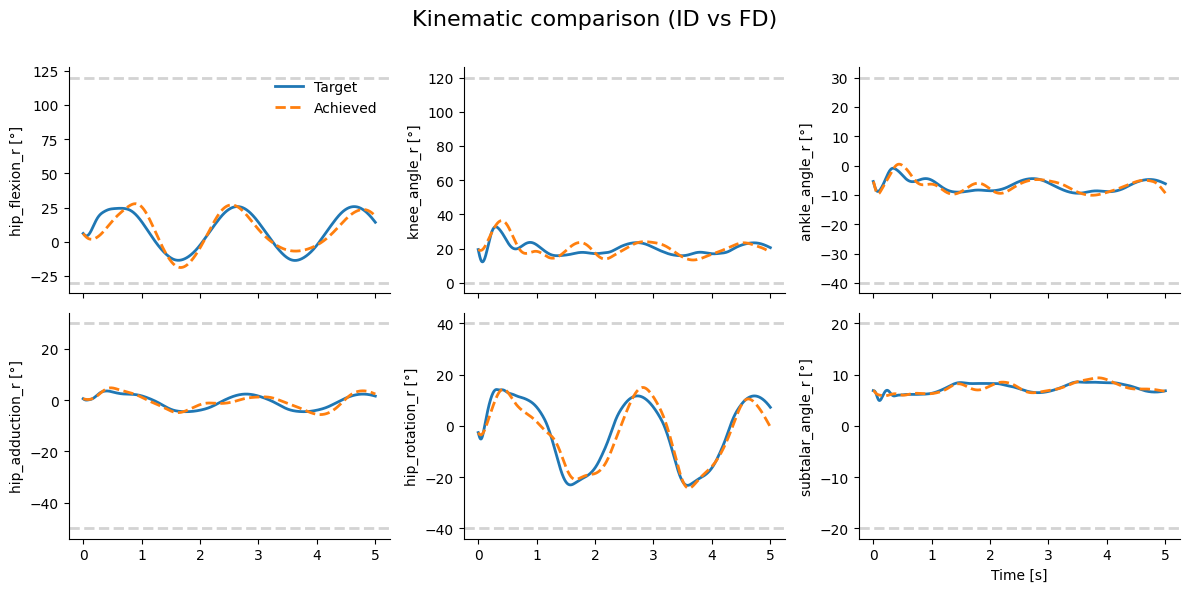

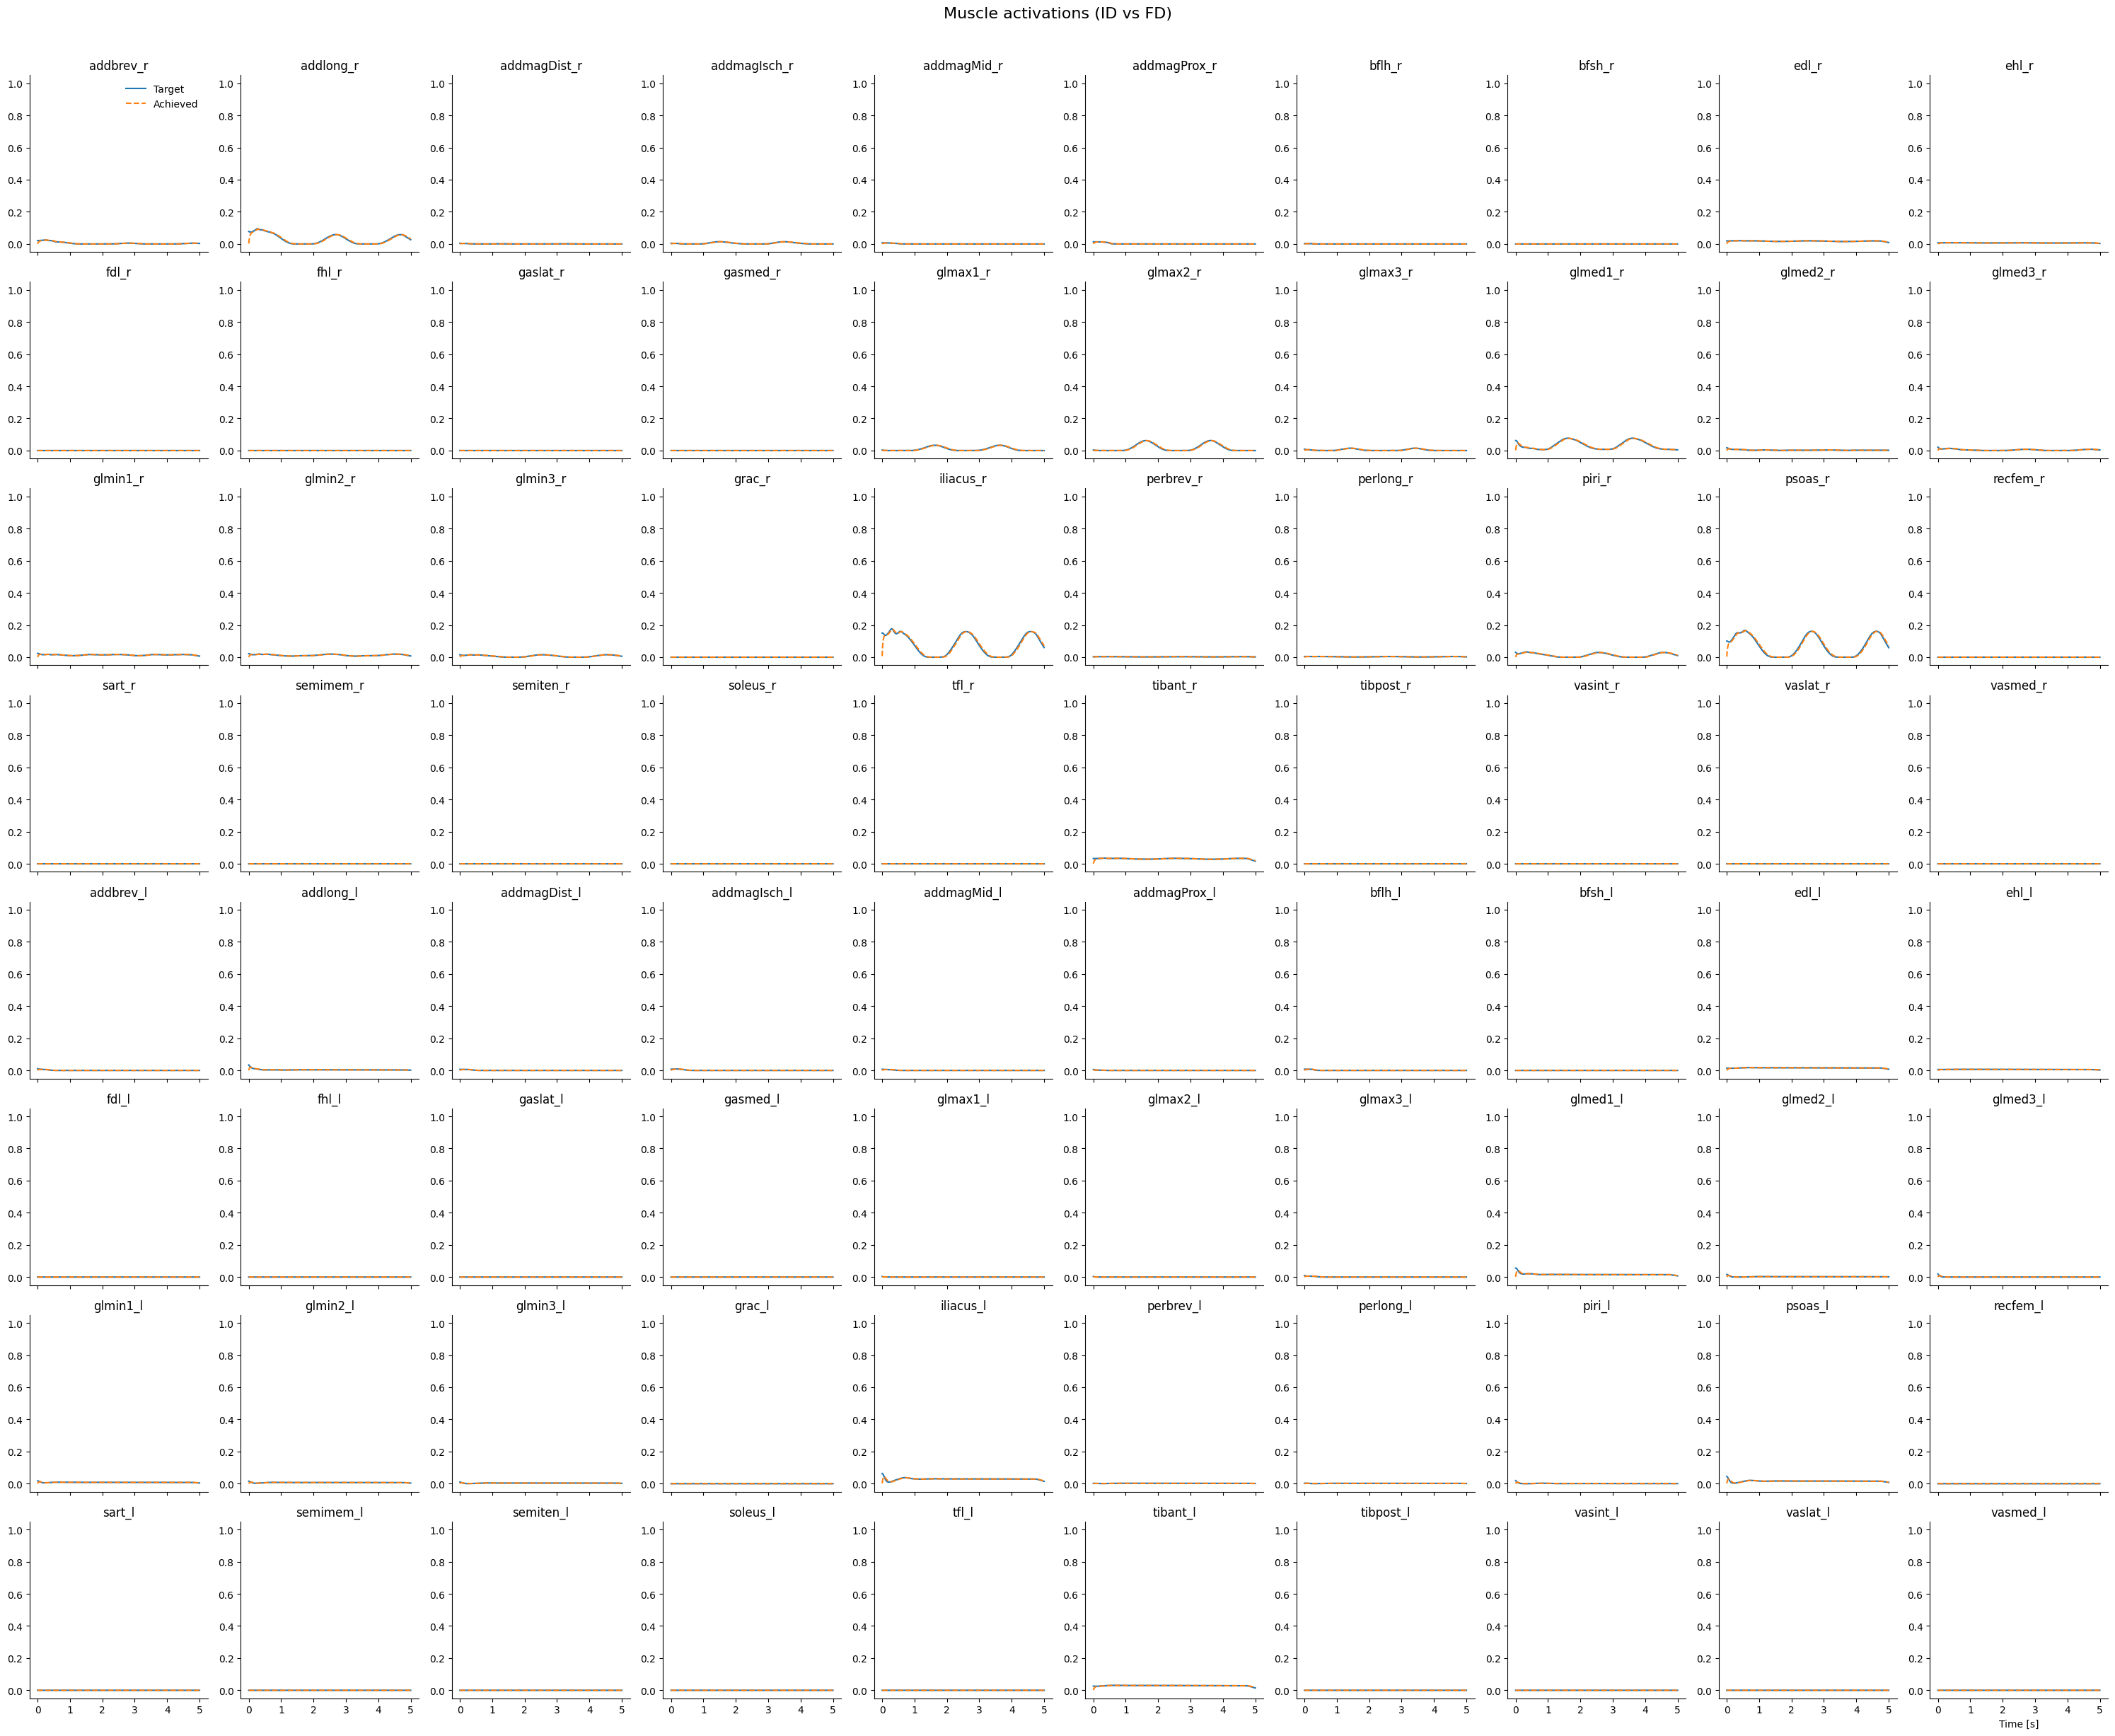

In [ ]:
# 1. Trajectory parameters
fs = 500  # Sampling frequency [Hz]
duration = 5  # Total duration [s]
n_samples = int(fs * duration)
time = np.linspace(0, duration, n_samples)

# 2. Create a sinusoidal trajectory for the first joint (amplitude 30°)
traj = np.zeros((n_samples, 6))  # 6 DOFs
traj[:, 0] = 20 * np.sin(2 * np.pi * 0.5 * time)  # 0.5 Hz sinusoid

# 3. Choose side ('r' or 'l') to define joints of interest
side = 'r'

# 4. Define joint indices of interest based on selected side
if side == 'l':
    qidxs_of_interest = np.array([14, 15])
elif side == 'r':
    qidxs_of_interest = np.array([0, 1])

# 5. Inverse dynamics: compute muscle activations from joint trajectory
activations, time_msk, qpos_id = inverse_dynamics(traj[:, :2], qidxs_of_interest, fs=fs, my_path='.')

# 6. Forward dynamics: simulate movement from computed activations
qpos_fd, qvel_fd, ctrl_fd, act_fd = forward_dynamics(activations, my_path='.', initial_qpos=qpos_id[0, :])

# 7. Compute RMSE between target and achieved joint trajectories
rmse = np.sqrt(np.mean((qpos_fd - qpos_id)**2, axis=0))
print(f'RMSE per joint:\n{rmse}')

# 8. Update joint indices to include more joints for plotting (optional)
qidxs_of_interest = np.array([0, 5, 8, 1, 2, 9]) 

# 9. Generate simulation time vector
time = np.linspace(0, qpos_fd.shape[0] * mjid.model.opt.timestep, qpos_fd.shape[0])

# 10. Plot comparison between inverse and forward dynamics joint positions
n_joints = len(qidxs_of_interest)
fig, axs = plt.subplots(int(n_joints / 3), 3, figsize=(12, 6), sharex=True)
axs = axs.flatten()

for i, idx in enumerate(qidxs_of_interest):
    ax = axs[i]
    ax.plot(time, np.degrees(qpos_id[:, idx]), label='Target', linewidth=2)
    ax.plot(time, np.degrees(qpos_fd[:, idx]), linestyle='--', label='Achieved', linewidth=2)
    ax.axhline(np.degrees(mjid.model.jnt_range[idx][0]), linestyle='--', linewidth=2, color='lightgray')
    ax.axhline(np.degrees(mjid.model.jnt_range[idx][1]), linestyle='--', linewidth=2, color='lightgray')
    ax.set_ylabel(f"{mjid.joint_names[idx]} [°]")
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    if i == 0:
        ax.legend(loc='upper right', frameon=False)

axs[-1].set_xlabel("Time [s]")
fig.suptitle("Kinematic comparison (ID vs FD)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# 11. Plot comparison between target and achieved muscle activations
n_muscles = activations.shape[1]
ncols = 10
nrows = int(np.ceil(n_muscles / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(30, 25), sharex=True)
axs = axs.flatten()

for i in range(n_muscles):
    ax = axs[i]
    ax.plot(time, activations[:, i], label='Target', linewidth=1.5)
    ax.plot(time, act_fd[:, i], linestyle='--', label='Achieved', linewidth=1.5)
    ax.set_title(mjid.muscle_names[i])
    ax.set_ylim(-0.05, 1.05)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    if i == 0:
        ax.legend(loc='upper right', frameon=False)

# Turn off unused subplots
for j in range(n_muscles, len(axs)):
    axs[j].axis('off')

axs[-1].set_xlabel("Time [s]")
fig.suptitle("Muscle activations (ID vs FD)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()